In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt

from copy import deepcopy
from datetime import datetime, timedelta

from configs.base_config import TrainingModuleConfig
from configs.base_config import ModelEvaluatorConfig

from modules.data_fetcher_module import DataFetcherModule
from modules.forecasting_module import ForecastingModule
from configs.base_config import ForecastingModuleConfig
from modules.model_evaluator import ModelEvaluator
from modules.training_module import TrainingModule

In [2]:
with open('../config/sample_training_config-generalised.json') as f_train, \
    open('../config/sample_evaluation_config-generalised.json') as f_test, \
    open('../config/sample_forecasting_config-generalised.json') as f_forecast:
    default_train_config = json.load(f_train)
    default_test_config = json.load(f_test)
    default_forecast_config = json.load(f_forecast)

In [3]:
default_train_config

{'region_name': 'mumbai',
 'region_type': 'district',
 'train_start_date': '3/22/20',
 'train_end_date': '4/1/20',
 'model_class': 'SEIR_gen',
 'model_parameters': {'incubation_period': 6},
 'latent_information': {'latent_variables': ['exposed', 'active'],
  'latent_on': 'confirmed'},
 'search_space': {'r0': [0.8, 6],
  'exposed_ratio': [1, 70],
  'active_ratio': [0.2, 1],
  'infectious_period': [0, 10],
  'hospitalization_period': [10, 20],
  'deceased_ratio': [0, 1]},
 'search_parameters': {'max_evals': 100},
 'training_loss_function': {'metric_name': 'mape',
  'variable_weights': [{'variable': 'confirmed', 'weight': 1}]},
 'loss_functions': [{'metric_name': 'mape',
   'variable_weights': [{'variable': 'confirmed', 'weight': 1}]},
  {'metric_name': 'rmse',
   'variable_weights': [{'variable': 'confirmed', 'weight': 1}]}],
 'output_filepath': 'seir_train.json'}

In [4]:
def parse_params(parameters, interval='Train1'):
    """
        Flatten the params dictionary to enable logging
    of the parameters.
    
    Assumptions:
        There is a maximum of one level of nesting.
        Ensured using an assert statement for now.
        
    Sample_input:
        {
            'LatentEbyCRatio': {
                '4/7/20': 0.5648337712691847,
                '4/17/20': 1.1427545912005197
            },
            'LatentIbyCRatio': {
                '4/7/20': 0.9610881623714099,
                '4/17/20': 0.6742970940209254
            }
        }
    
    Output:
        {
            'Train1_LatentEbyCRatio_4/7/20': 0.5648337712691847,
            'Train1_LatentEbyCRatio_4/17/20': 1.1427545912005197,
            'Train1_LatentIbyCRatio_4/7/20': 0.9610881623714099,
            'Train1_LatentIbyCRatio_4/17/20': 0.6742970940209254
        }
    """
    param_dict = dict() # The flattened dictionary to return
    for param in parameters:
        if isinstance(parameters[param], dict):
            for key in parameters[param]:
                assert (not isinstance(parameters[param][key], dict))
                
                param_dict[interval + '_' + param + '_'+ key] = parameters[param][key]
        else:
            param_dict[interval + '_' + param] = parameters[param]
    return param_dict

In [5]:
def train_eval(region, region_type, 
               train1_start_date, train1_end_date, 
               train2_start_date, train2_end_date, run_day,
               test_start_date, test_end_date,
               max_evals = 1000, data_source = None, 
               mlflow_log = True, name_prefix = None):
    """
        #TODO: Need to add hooks to consume data from appropriate source

        Run train and evalation for (basic) SEIR model.
    
    Arguments:
        region, region_type : Region info corresponding to the run
        train1_start_date, train1_end_date : Train1 durations
        train2_start_date, train2_end_date : Train2 durations
        test_start_date, test_end_date, run_day : Test durations
        max_evals : number of search evaluations for SEIR (default: 1000)
        data_source : Data source for picking the region data
        mlflow_log : Experiment logged using MLFlow (default: True)
        name_prefix : In case of non-MLFlow experiment, string prefix to
                      enable easy indexing of experiments

    Note:
        date_format : %-m/%-d/%-y

    Returns: 
        params : Run parameters to be logged
        metrics : Metrics collected from the run 
    
    Output files saved : (name_prefix added in the case of non-MLflow experiments)
        Train1 : train1_output.json (name_prefix + '_train1_output.json')
        Train2 : train2_output.json (name_prefix + '_train2_output.json')
        Test   : test_output.json   (name_prefix + '_test_output.json')
    """
    
    # Save metrics and params for logging
    params = dict()
    metrics = dict()

    params['region'] = region
    params['region_type'] = region_type
    params['train1_start_date'] = train1_start_date
    params['train1_end_date'] = train1_end_date
    params['train2_start_date'] = train2_start_date
    params['train2_end_date'] = train2_end_date
    params['run_day'] = run_day
    params['test_start_date'] = test_start_date
    params['test_end_date'] = test_end_date
    params['data_source'] = data_source

    train_config = deepcopy(default_train_config)
    train_config['region_name'] = region
    train_config['region_type'] = region_type
    train_config['train_start_date'] = train1_start_date
    train_config['train_end_date'] = train1_end_date
    train_config['search_parameters']['max_evals'] = max_evals
    
    # model parameters
    model_params = dict()
    model_params['region'] = region
    model_params['region_type'] = region_type
    model_params['model_type'] = train_config['model_class']
       
    if mlflow_log:
        train_config['output_filepath'] = 'train1_output.json'
    else:
        assert name_prefix is not None
        train_config['output_filepath'] = name_prefix + '_train1_output.json'

    train_module_config = TrainingModuleConfig.parse_obj(train_config)
    trainResults = TrainingModule.from_config(train_module_config)
    print(trainResults)
    metrics['Train1MAPE'] = trainResults['train_metric_results'][0]['value']
    metrics['Train1RMLSE'] = trainResults['train_metric_results'][1]['value']
    metrics['Train1All'] = trainResults['train_metric_results']
    metrics.update(parse_params(trainResults['best_params'], 'Train1'))
    metrics.update(parse_params(trainResults['latent_params'], 'Train1')) 
    
    test_config = deepcopy(default_test_config)
    test_config['region_name'] = region
    test_config['region_type'] = region_type
    test_config['test_start_date'] = test_start_date
    test_config['test_end_date'] = test_end_date
    test_config['run_day'] = run_day
#     test_config['model_parameters'].update(trainResults['best_params'])    
#     test_config['model_parameters'].update(trainResults['latent_params'])  
    test_config['model_parameters'].update(trainResults['model_parameters'])  
        
    if mlflow_log:
        test_config['output_filepath'] = 'test_output.json'
    else:
        test_config['output_filepath'] = name_prefix + '_test_output.json'

    test_module_config = ModelEvaluatorConfig.parse_obj(test_config) 
    evalResults = ModelEvaluator.from_config(test_module_config)
    
    metrics['TestMAPE'] = evalResults[0]['value']
    metrics['TestRMLSE'] = evalResults[1]['value']
    metrics['TestAll'] = evalResults
    
    finalTrain_config = deepcopy(default_train_config)
    finalTrain_config['region_name'] = region
    finalTrain_config['region_type'] = region_type
    finalTrain_config['train_start_date'] = train2_start_date
    finalTrain_config['train_end_date'] = train2_end_date
    finalTrain_config['search_parameters']['max_evals'] = max_evals
    
    if mlflow_log:
        finalTrain_config['output_filepath'] = 'train2_output.json'
    else:
        finalTrain_config['output_filepath'] = name_prefix + '_train2_output.json'

    finalTrain_module_config = TrainingModuleConfig.parse_obj(finalTrain_config)
    finalResults = TrainingModule.from_config(finalTrain_module_config)
    
    metrics['Train2MAPE'] = finalResults['train_metric_results'][0]['value']
    metrics['Train2RMLSE'] = finalResults['train_metric_results'][1]['value']
    metrics['Train2All'] = finalResults['train_metric_results']
    metrics.update(parse_params(finalResults['best_params'], 'Train2'))
    metrics.update(parse_params(finalResults['latent_params'], 'Train2'))
        
    model_params['model_parameters'] = finalResults['model_parameters']
    
    return params, metrics, model_params

In [6]:
region = 'mumbai'
region_type = 'district'
train1_start_date = '4/8/20'
train1_end_date = '4/17/20'
train2_start_date = '4/13/20'
train2_end_date = '4/22/20'
test_start_date = '4/18/20'
test_end_date = '4/22/20'
run_day = '4/17/20'

params, metrics, model_params = train_eval(region, region_type, 
                                           train1_start_date, train1_end_date, 
                                           train2_start_date, train2_end_date, run_day,
                                           test_start_date, test_end_date,
                                           max_evals = 10,
                                           mlflow_log = False,
                                           name_prefix = 'mumbai_sample')

100%|██████████| 10/10 [00:00<00:00, 25.38trial/s, best loss: 74.67857416427128]
Best fit: {'active_ratio': 0.6379084903065975, 'deceased_ratio': 0.3640533182978397, 'exposed_ratio': 11.349911128057457, 'hospitalization_period': 19.139368999033223, 'infectious_period': 8.34617536168825, 'r0': 2.6501037790848825}
Best Loss: 74.67857416427128
{'best_params': {'active_ratio': 0.6379084903065975, 'deceased_ratio': 0.3640533182978397, 'exposed_ratio': 11.349911128057457, 'hospitalization_period': 19.139368999033223, 'infectious_period': 8.34617536168825, 'r0': 2.6501037790848825}, 'best_loss': 74.67857416427128, 'latent_params': {'Latent_exposed_ratio': {'4/7/20': 11.349911128057457, '4/17/20': 2.230773732396292}, 'Latent_active_ratio': {'4/7/20': 0.6379084903065975, '4/17/20': 1.482495800264048}}, 'model_parameters': {'incubation_period': 6, 'active_ratio': 0.6379084903065975, 'deceased_ratio': 0.3640533182978397, 'exposed_ratio': 11.349911128057457, 'hospitalization_period': 19.1393689990

In [7]:
params

{'region': 'mumbai',
 'region_type': 'district',
 'train1_start_date': '4/8/20',
 'train1_end_date': '4/17/20',
 'train2_start_date': '4/13/20',
 'train2_end_date': '4/22/20',
 'run_day': '4/17/20',
 'test_start_date': '4/18/20',
 'test_end_date': '4/22/20',
 'data_source': None}

In [8]:
metrics

{'Train1MAPE': 74.67857416427128,
 'Train1RMLSE': 1832.078272230374,
 'Train1All': [{'metric_name': <MetricName.mape: 'mape'>,
   'variable_weights': [{'variable': <ForecastVariable.confirmed: 'confirmed'>,
     'weight': 1.0}],
   'value': 74.67857416427128},
  {'metric_name': <MetricName.rmse: 'rmse'>,
   'variable_weights': [{'variable': <ForecastVariable.confirmed: 'confirmed'>,
     'weight': 1.0}],
   'value': 1832.078272230374}],
 'Train1_active_ratio': 0.6379084903065975,
 'Train1_deceased_ratio': 0.3640533182978397,
 'Train1_exposed_ratio': 11.349911128057457,
 'Train1_hospitalization_period': 19.139368999033223,
 'Train1_infectious_period': 8.34617536168825,
 'Train1_r0': 2.6501037790848825,
 'Train1_Latent_exposed_ratio_4/7/20': 11.349911128057457,
 'Train1_Latent_exposed_ratio_4/17/20': 2.230773732396292,
 'Train1_Latent_active_ratio_4/7/20': 0.6379084903065975,
 'Train1_Latent_active_ratio_4/17/20': 1.482495800264048,
 'TestMAPE': 21.9785746469059,
 'TestRMLSE': 0.23219862

In [9]:
model_params

{'region': 'mumbai',
 'region_type': 'district',
 'model_type': 'SEIR_gen',
 'model_parameters': {'incubation_period': 6,
  'active_ratio': 0.6375657023263026,
  'deceased_ratio': 0.7865209060178201,
  'exposed_ratio': 9.196867260335578,
  'hospitalization_period': 15.539306759104416,
  'infectious_period': 8.63182224411649,
  'r0': 5.667659926225756,
  'Latent_exposed_ratio': {'4/12/20': 9.196867260335578,
   '4/22/20': 5.089570932471245},
  'Latent_active_ratio': {'4/12/20': 0.6375657023263026,
   '4/22/20': 2.2823041452612416},
  'MAPE': 152.4605625625579}}

In [10]:
model_params['model_parameters']['incubation_period'] = 5

In [11]:
model_params

{'region': 'mumbai',
 'region_type': 'district',
 'model_type': 'SEIR_gen',
 'model_parameters': {'incubation_period': 5,
  'active_ratio': 0.6375657023263026,
  'deceased_ratio': 0.7865209060178201,
  'exposed_ratio': 9.196867260335578,
  'hospitalization_period': 15.539306759104416,
  'infectious_period': 8.63182224411649,
  'r0': 5.667659926225756,
  'Latent_exposed_ratio': {'4/12/20': 9.196867260335578,
   '4/22/20': 5.089570932471245},
  'Latent_active_ratio': {'4/12/20': 0.6375657023263026,
   '4/22/20': 2.2823041452612416},
  'MAPE': 152.4605625625579}}

In [12]:
def forecast(model_params, run_day, forecast_start_date, forecast_end_date):
    evalConfig = ForecastingModuleConfig.parse_obj(default_forecast_config)
    evalConfig.region_name = model_params['region']
    evalConfig.region_type = model_params['region_type']
    evalConfig.model_parameters = model_params['model_parameters']

    evalConfig.run_day = run_day
    evalConfig.forecast_start_date = forecast_start_date
    evalConfig.forecast_end_date = forecast_end_date
    
    forecast_json = ForecastingModule.from_config(evalConfig)
    forecast_df = pd.read_json(forecast_json)
    forecast_df = forecast_df.drop(columns=['Region Type', 'Region', 'Country', 'Lat', 'Long'])
    forecast_df = forecast_df.set_index('prediction_type')
    forecast_df = forecast_df.transpose().reset_index()
    return forecast_df

In [13]:
run_day = '4/12/20'
forecast_start_date = '4/13/20'
forecast_end_date = '4/22/20'
forecast_df = forecast(model_params, run_day, forecast_start_date, forecast_end_date)

In [14]:
forecast_df

prediction_type,index,active_mean,exposed,hospitalized_mean,recovered_mean,deceased_mean,confirmed_mean,active_min,active_max,hospitalized_min,hospitalized_max,recovered_min,recovered_max,deceased_min,deceased_max,confirmed_min,confirmed_max
0,4/13/20,2936.954130,11765.857499,1363.685805,-22.266638,106.303598,1447.722766,-1540.742659,7414.650919,-715.397245,3442.768856,11.681203,-56.214478,-55.767465,268.374661,-759.483507,3654.929038
1,4/14/20,4997.256815,13724.120696,1723.286814,-48.922979,231.169883,1905.533717,-2621.589038,12616.102669,-904.045957,4350.619584,25.665270,-123.511228,-121.273021,583.612786,-999.653708,4810.721142
2,4/15/20,7382.845602,17592.489527,2307.542847,-83.769545,394.401635,2618.174936,-3873.082336,18638.773541,-1210.549959,5825.635653,43.945975,-211.485066,-206.905316,995.708586,-1373.509301,6609.859173
3,4/16/20,10434.589938,23521.092108,3156.939033,-131.070718,615.974490,3641.842805,-5474.044583,26343.224459,-1656.147977,7970.026043,68.760436,-330.901871,-323.143682,1555.092662,-1910.531223,9194.216834
4,4/17/20,14504.724382,32019.050939,4350.864826,-196.050502,920.359256,5075.173579,-7609.260009,36618.708772,-2282.488164,10984.217815,102.849196,-494.950200,-482.825643,2323.544154,-2662.464611,12812.811770
5,4/18/20,20047.551204,43864.758803,6004.888312,-285.743681,1340.508963,7059.653595,-10517.058142,50612.160551,-3150.198190,15159.974814,149.902742,-721.390104,-703.238543,3384.256469,-3703.533991,17822.841180
6,4/19/20,27630.383620,60248.832208,8286.775478,-409.453841,1920.004397,9797.326033,-14495.054685,69755.821926,-4347.289034,20920.839989,214.801788,-1033.709470,-1007.245108,4847.253901,-5139.732353,24734.384420
7,4/20/20,38044.586930,82831.574007,11431.712919,-580.222102,2719.934066,13571.424883,-19958.404328,96047.578188,-5997.140908,28860.566745,304.387779,-1464.831983,-1426.892713,6866.760846,-7119.645841,34262.495608
8,4/21/20,52356.537387,113842.993095,15757.628782,-815.700845,3822.987008,18764.914946,-27466.534052,132179.608826,-8266.540706,39781.798270,427.921252,-2059.322941,-2005.560491,9651.534507,-9844.179945,47374.009836
9,4/22/20,72007.138556,156374.216588,21704.740344,-1140.044436,5342.309510,25907.005418,-37775.349972,181789.627084,-11386.428887,54795.909575,598.073724,-2878.162596,-2802.605623,13487.224643,-13590.960785,65404.971622


In [15]:
def get_observations_in_range(region_name, region_type, 
                              start_date, end_date,
                              obs_type = 'confirmed'):
    """
        Return a list of counts of obs_type cases
        from the region in the specified date range.
    """
    observations = DataFetcherModule.get_observations_for_region(region_type, region_name)
    observations_df = observations[observations['observation'] == obs_type]
    
    start_date = datetime.strptime(start_date, '%m/%d/%y')
    end_date = datetime.strptime(end_date, '%m/%d/%y')
    delta = (end_date - start_date).days
    days = []
    for i in range(delta + 1):
        days.append((start_date + timedelta(days=i)).strftime('%-m/%-d/%-y'))
    
    # Fetch observations in the date range
    observations_df = observations_df[days]
    
    # Transpose the df to get the
    # observations_df.shape = (num_days, 1)
    observations_df = observations_df.reset_index(drop=True).transpose()
    
    # Rename the column to capture observation type
    # Note that the hardcoded 0 in the rename comes from the reset_index
    # from the previous step
    observations = observations_df[0].to_list()
    return observations

In [16]:
forecast_df.columns

Index(['index', 'active_mean', 'exposed', 'hospitalized_mean',
       'recovered_mean', 'deceased_mean', 'confirmed_mean', 'active_min',
       'active_max', 'hospitalized_min', 'hospitalized_max', 'recovered_min',
       'recovered_max', 'deceased_min', 'deceased_max', 'confirmed_min',
       'confirmed_max'],
      dtype='object', name='prediction_type')

In [17]:
observations = get_observations_in_range('mumbai', 'district', '4/13/20', '4/22/20')

In [18]:
forecast_df['actual_confirmed'] = observations

In [19]:
forecast_df[['confirmed_mean', 'hospitalized_mean', 'recovered_mean', 'icu_mean', 'final', 'deceased_mean', 'actual_confirmed']]

KeyError: "['icu_mean', 'final'] not in index"

In [20]:
def plot(model_params, forecast_df, forecast_start_date, forecast_end_date, plot_name = 'default.png'):
    """
        Plot actual_confirmed cases vs forecasts.
        
        Assert that forecast_end_date is prior to the current date
        to ensure availability of actual_counts.
    """
    # Check for forecast_end_date being prior to current date
    end_date = datetime.strptime(forecast_end_date, '%m/%d/%y')
    assert end_date < datetime.now()    
    
    # Fetch actual counts from the DataFetcher module
    region_name = model_params['region']
    region_type = model_params['region_type']
    actual_observations = DataFetcherModule.get_observations_for_region(region, region_type)
    
    # Get relevant time-series of actual counts from actual_observations
    actual_observations = get_observations_in_range(region_name, region_type, 
                                                    forecast_start_date, 
                                                    forecast_end_date,
                                                    obs_type = 'confirmed')
    
    forecast_df['actual_confirmed'] = actual_observations
    
    fig, ax = plt.subplots(figsize=(15, 5))
    fig.suptitle(model_params['region'])
    ax.plot(forecast_df['index'], forecast_df['actual_confirmed'], color='blue', label="actual_confirmed")
    ax.plot(forecast_df['index'], forecast_df['confirmed_mean'], color='orange', label="predicted_confirmed")
    ax.set_ylim(ymin=0)
    ax.legend()

    plt.savefig(plot_name)

In [21]:
plot(model_params, forecast_df, forecast_start_date, forecast_end_date)

KeyboardInterrupt: 

In [22]:
def train_eval_forecast(region, region_type, 
                        train1_start_date, train1_end_date, 
                        train2_start_date, train2_end_date,
                        test_run_day, test_start_date, test_end_date, 
                        forecast_run_day, forecast_start_date, forecast_end_date,
                        max_evals = 1000, 
                        data_source = None, mlflow_log = True, name_prefix = None,
                        plot_actual_vs_predicted = False, plot_name = 'default.png'):
    """
        Run train, evaluation and generate forecasts as a dataframe.
        
        If plot_actual_vs_predicted is set to True,
        we first check if the forecast_end_date is prior to the current date
        so that we have actual_confirmed cases and then plot the predictions.
    """
    params, metrics, model_params = train_eval(region, region_type, 
                                               train1_start_date, train1_end_date, 
                                               train2_start_date, train2_end_date, 
                                               test_run_day, test_start_date, test_end_date, 
                                               max_evals, data_source, 
                                               mlflow_log, name_prefix)
    model_params['model_parameters']['incubation_period'] = 5
    forecast_df = forecast(model_params, run_day, forecast_start_date, forecast_end_date)
    
    if plot_actual_vs_predicted:
        # Check for forecast_end_date being prior to current date
        end_date = datetime.strptime(forecast_end_date, '%m/%d/%y')
        assert end_date < datetime.now()

        plot(model_params, forecast_df, forecast_start_date, forecast_end_date, plot_name)
    return forecast_df, params, metrics, model_params

100%|██████████| 1000/1000 [00:52<00:00, 19.22trial/s, best loss: 2.544887279192117]
Best fit: {'active_ratio': 0.8750447750995367, 'deceased_ratio': 0.9304048049079789, 'exposed_ratio': 2.3345107490806285, 'hospitalization_period': 14.040945866533557, 'infectious_period': 4.449373664917995, 'r0': 0.842912422403656}
Best Loss: 2.544887279192117
{'best_params': {'active_ratio': 0.8750447750995367, 'deceased_ratio': 0.9304048049079789, 'exposed_ratio': 2.3345107490806285, 'hospitalization_period': 14.040945866533557, 'infectious_period': 4.449373664917995, 'r0': 0.842912422403656}, 'best_loss': 2.544887279192117, 'latent_params': {'Latent_exposed_ratio': {'4/7/20': 2.3345107490806285, '4/17/20': 0.35480013871364435}, 'Latent_active_ratio': {'4/7/20': 0.8750447750995367, '4/17/20': 0.3091593247036946}}, 'model_parameters': {'incubation_period': 6, 'active_ratio': 0.8750447750995367, 'deceased_ratio': 0.9304048049079789, 'exposed_ratio': 2.3345107490806285, 'hospitalization_period': 14.040

(prediction_type    index  active_mean      exposed  hospitalized_mean  \
 0                4/13/20   820.999979  1224.744303        1372.662136   
 1                4/14/20   814.670900  1121.737103        1511.792732   
 2                4/15/20   793.460464  1035.448903        1637.579349   
 3                4/16/20   764.302190   960.702406        1747.099584   
 4                4/17/20   730.125488   895.111119        1840.430837   
 5                4/18/20   693.715632   836.409211        1917.554828   
 6                4/19/20   657.345206   782.705312        1978.669505   
 7                4/20/20   621.277641   733.516798        2025.401442   
 8                4/21/20   585.915029   688.282778        2059.100038   
 9                4/22/20   552.035706   646.198642        2080.662305   
 
 prediction_type  recovered_mean  deceased_mean  confirmed_mean  active_min  \
 0                    -73.348884     166.773387     1466.086638  788.224050   
 1                   -154.

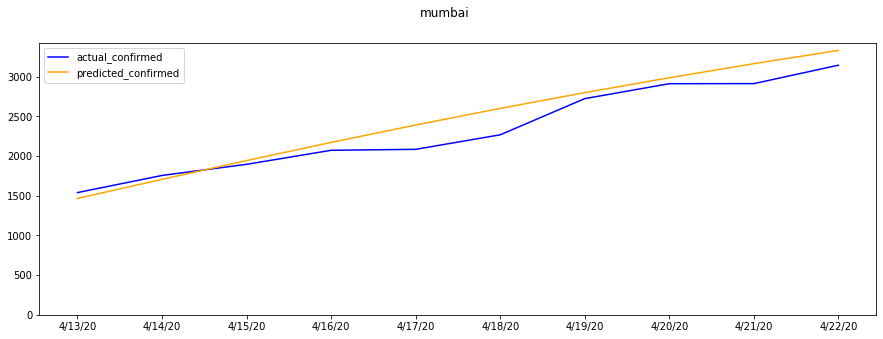

In [24]:
region = 'mumbai'
region_type = 'district'
train1_start_date = '4/8/20'
train1_end_date = '4/17/20'
train2_start_date = '4/13/20'
train2_end_date = '4/22/20'
test_start_date = '4/18/20'
test_end_date = '4/22/20'
test_run_day = '4/17/20'
forecast_run_day = '4/12/20'
forecast_start_date = '4/13/20'
forecast_end_date = '4/22/20'
name_prefix = 'mumbai_sample'

train_eval_forecast(region, region_type, 
                    train1_start_date, train1_end_date, 
                    train2_start_date, train2_end_date,
                    test_run_day, test_start_date, test_end_date, 
                    forecast_run_day, forecast_start_date, forecast_end_date,
                    max_evals = 1000, 
                    mlflow_log = False, name_prefix = name_prefix,
                    plot_actual_vs_predicted = 'True',
                    plot_name = 'default.png')